In [4]:
import os
import sys
# !{sys.executable} -m pip install python-csv
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install pandas;
# print(pd.__version__)

sys.path.insert(1, 'lib')

import pandas as pd
from display import Display
from mock_db import Database
    
db = Database(os.getcwd(), 'cronos-2021-10-15')   
Display.header('ALP tables', 'h1')

Display.header('Participants table', 'h2')
participants_df = db.get_participants()
print('Number of users:', original_participants_df.shape[0])
Display.frame(original_participants_df, 5)

Display.header('Responses table', 'h2')
responses_df = db.get_responses().drop(columns=['INTERACTION_ID'])
print('Number of responses:', responses_df.shape[0])
Display.frame(responses_df, 5)

Number of users: 62


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE
0,2475,Uniclinic-Dresden-05,enrolled,2021-05-08,NaT
1,3121,anonymous,enrolled,2021-04-27,NaT
2,3133,Data4Life-test-05,withdrawn,2021-07-07,2021-07-07
3,2012,Uniclinic-Dresden-59,enrolled,2021-06-15,NaT
4,3128,Uniclinic-Dresden-51,enrolled,2021-07-22,NaT


Number of responses: 1488


,Unnamed: 0,ALP_ID,VERSION,AUTHORED,QUESTIONNAIRE,LINK_ID,VALUE,VALUECODING_CODE,LANGUAGE,TEXT
0,1,1505,1.0.0,2021-05-19,Q1_personal_info,where_coronoa_treated,NaN,Intensivstation,en,How was your COVID-19 treated?
1,2,1505,1.0.0,2021-05-19,Q1_personal_info,when_coronoa_infection,2021-05-03,NaN,en,When did you first test positive for the coronavirus?
2,3,1505,1.0.0,2021-05-19,Q1_personal_info,how_many_kids,2,NaN,en,How many children do you already have (excluding the current pregnancy)?
3,4,1505,1.0.0,2021-05-19,Q1_personal_info,what_postal_code,12345,NaN,en,What's the postal code of your place of residence?
4,5,1505,1.0.0,2021-05-19,Q1_personal_info,when_expected_delivery,2021-05-05,NaN,en,When is your calculated due date?


In [19]:
from study import CronosStudy, ParticipantsBuilder
from display import Display

from datetime import datetime, timedelta
import pandas as pd
import math 

import pandas as pd
import math 

study = CronosStudy()
builder = ParticipantsBuilder(study, participants_df, responses_df)
df = builder.filter_data4life_users() \
    .filter_annonymous_users() \
    .add_last_donation() \
    .add_all_submissions() \
    .add_answer('Q1_personal_info', 'when_expected_delivery', 'EXPECTED_BIRTH') \
    .add_answer(None, 'when_delivery_date', 'ACTUAL_BIRTH') \
    .get()

def days_after_delivery(row):
    return (datetime.now() - datetime.strptime(row['EXPECTED_BIRTH'], "%Y-%m-%d")).days if row['DELIVERED'] else 0

def calculate_expected_q3(row):
    last_donation = datetime.now() - timedelta(days=datetime.now().weekday())
    days = (last_donation - row['ENROLED_ON']).days - row['DAYS_AFTER_DELIVERY']
    if days < 7:
        return 0
    return 1 + math.floor((days - 7) / 28)

df['DELIVERED'] = datetime.now() >= pd.to_datetime(df['EXPECTED_BIRTH'], format="%Y-%m-%d")
df['DAYS_AFTER_DELIVERY'] = df.apply(lambda row : days_after_delivery(row), axis = 1)
df['expected:Q3'] = df.apply(lambda row : calculate_expected_q3(row), axis = 1)
df['expected:Q5'] = (datetime.now() - pd.to_datetime(df['EXPECTED_BIRTH'], format="%Y-%m-%d")).dt.days > 42

Display.header('Submissions table', 'h2')
Display.frame(df)

,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,LAST_DONATION,all,Q1,Q2a,Q2b,Q3,Q3a,Q3b,Q6,Q5,EXPECTED_BIRTH,ACTUAL_BIRTH,DELIVERED,DAYS_AFTER_DELIVERY,expected:Q3,expected:Q5
0,2475,Uniclinic-Dresden-05,enrolled,2021-05-08,NaT,2021-05-08,2021-08-05,9,1,1,1,2,1,1,1,1,2021-06-29,2021-06-24,True,108,2,True
1,2012,Uniclinic-Dresden-59,enrolled,2021-06-15,NaT,2021-06-15,2021-09-13,7,1,1,0,4,0,0,1,0,2021-10-12,NaN,True,3,4,False
2,3128,Uniclinic-Dresden-51,enrolled,2021-07-22,NaT,2021-07-22,2021-09-06,8,1,1,1,2,1,1,1,0,2021-09-04,2021-08-30,True,41,2,False
3,3147,Uniclinic-Dresden-57,enrolled,2021-07-21,NaT,2021-07-21,2021-09-09,8,1,1,1,1,0,2,1,1,2021-08-05,2021-07-29,True,71,1,True
4,2879,Uniclinic-Dresden-29,enrolled,2021-05-13,NaT,2021-05-13,2021-09-13,12,1,1,1,3,2,2,1,1,2021-07-28,2021-08-02,True,79,3,True
5,2739,Uniclinic-Dresden-15,enrolled,2021-06-04,NaT,2021-06-04,2021-08-27,8,1,1,1,2,1,1,1,0,2021-08-25,2021-08-26,True,51,3,True
6,2077,Uniclinic-Dresden-37,enrolled,2021-06-03,NaT,2021-06-03,2021-09-02,7,1,1,0,4,0,0,1,0,2021-12-03,NaN,False,0,5,False
7,1549,Uniclinic-Dresden-13,enrolled,2021-05-07,NaT,2021-05-07,2021-09-12,10,1,1,1,5,0,1,1,0,2021-09-22,2021-09-01,True,23,5,False
8,3148,Uniclinic-Dresden-43,enrolled,NaT,NaT,2021-07-02,2021-09-29,7,1,1,0,4,0,0,1,0,2022-01-07,NaN,False,0,4,False
9,5187,Uniclinic-Dresden-53,enrolled,2021-08-09,NaT,2021-08-09,2021-09-28,5,1,1,0,2,0,0,1,0,2021-12-10,NaN,False,0,3,False


In [20]:
temp = df[['ALP_ID', 'EXTERNAL_ID', 'ENROLED_ON', 'LAST_DONATION', 'DELIVERED', 'Q5']].copy()
temp['TIME'] = temp['LAST_DONATION'] - temp['ENROLED_ON'] 
temp.rename(columns={'Q5': 'FINISHED'}, inplace=True)

Display.header('Participants: in-progress, post delivery, finished study', 'h2')
Display.frame(temp)

,ALP_ID,EXTERNAL_ID,ENROLED_ON,LAST_DONATION,DELIVERED,FINISHED,TIME
0,2475,Uniclinic-Dresden-05,2021-05-08,2021-08-05,True,1,89 days
1,2012,Uniclinic-Dresden-59,2021-06-15,2021-09-13,True,0,90 days
2,3128,Uniclinic-Dresden-51,2021-07-22,2021-09-06,True,0,46 days
3,3147,Uniclinic-Dresden-57,2021-07-21,2021-09-09,True,1,50 days
4,2879,Uniclinic-Dresden-29,2021-05-13,2021-09-13,True,1,123 days
5,2739,Uniclinic-Dresden-15,2021-06-04,2021-08-27,True,0,84 days
6,2077,Uniclinic-Dresden-37,2021-06-03,2021-09-02,False,0,91 days
7,1549,Uniclinic-Dresden-13,2021-05-07,2021-09-12,True,0,128 days
8,3148,Uniclinic-Dresden-43,2021-07-02,2021-09-29,False,0,89 days
9,5187,Uniclinic-Dresden-53,2021-08-09,2021-09-28,False,0,50 days


In [21]:
Display.header('Delivery date: Expected vs Actual', 'h2')
result = df[['EXPECTED_BIRTH', 'ACTUAL_BIRTH', 'ENROLED_ON', 'LAST_DONATION']]
Display.frame(result)

,EXPECTED_BIRTH,ACTUAL_BIRTH,ENROLED_ON,LAST_DONATION
0,2021-06-29,2021-06-24,2021-05-08,2021-08-05
1,2021-10-12,NaN,2021-06-15,2021-09-13
2,2021-09-04,2021-08-30,2021-07-22,2021-09-06
3,2021-08-05,2021-07-29,2021-07-21,2021-09-09
4,2021-07-28,2021-08-02,2021-05-13,2021-09-13
5,2021-08-25,2021-08-26,2021-06-04,2021-08-27
6,2021-12-03,NaN,2021-06-03,2021-09-02
7,2021-09-22,2021-09-01,2021-05-07,2021-09-12
8,2022-01-07,NaN,2021-07-02,2021-09-29
9,2021-12-10,NaN,2021-08-09,2021-09-28


In [23]:
df = result.copy()
df['date_expected'] = pd.to_datetime(df['EXPECTED_BIRTH']).dt.to_period('m')
df['date_actual'] = pd.to_datetime(df['ACTUAL_BIRTH']).dt.to_period('m')

df1 = df.groupby(by=['date_expected']).count().sort_index()[['EXPECTED_BIRTH']].reset_index().rename(columns = {'date_expected': 'date'})
df2 = df.groupby(by=['date_actual']).count().sort_index()[['ACTUAL_BIRTH']].reset_index().rename(columns = {'date_actual': 'date'})
df = pd.merge(df1, df2, how='outer', on=['date']) 

Display.header('Expected/Actual births per month', 'h2')
df.head()

,date,EXPECTED_BIRTH,ACTUAL_BIRTH
0,2021-06,1,1.0
1,2021-07,1,1.0
2,2021-08,2,3.0
3,2021-09,3,2.0
4,2021-10,1,NaN


Current week is: 41,2021


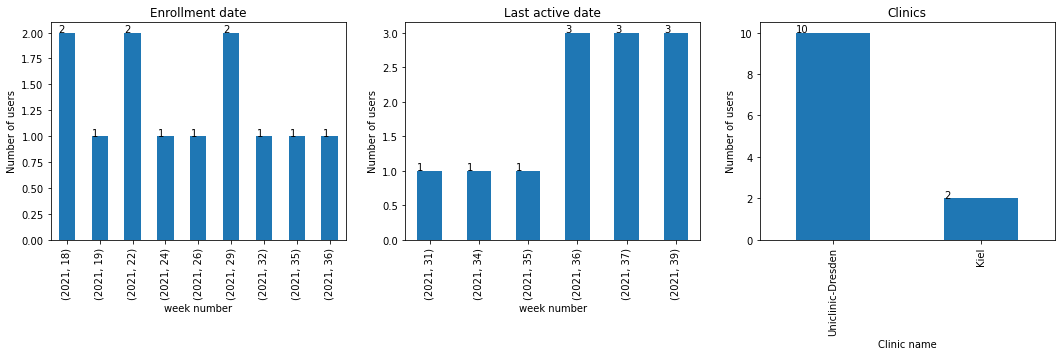

In [50]:
from matplotlib import pyplot as plt
import math

def count_on_timeline(data, column_name):
    df = data[[column_name]].copy()
    df['date_week'] = df[column_name].apply(lambda x: x.isocalendar()[1])
    df['date_year'] = df[column_name].apply(lambda x: x.isocalendar()[0])
    return df.groupby(by=['date_year', 'date_week']).count().sort_index()
    
def get_current_week():    
    week_now = datetime.now().date().isocalendar()[1]
    year_now = datetime.now().date().isocalendar()[0]
    return f'{week_now},{year_now}'

def tag_bars(ax, size=None):
    for p in ax.patches:
        value = f'{round(100 * p.get_height() / size, 2)}%' if size else f'{p.get_height()}'
        ax.annotate(value, (p.get_x() * 1.005, p.get_height() * 1.005))
        
Display.header('Participants enrollment', 'h2')
print('Current week is:', get_current_week())

fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))

df = result.copy()
value_counts = count_on_timeline(df, 'ENROLED_ON')
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='week number', title='Enrollment date', legend=None, ax=ax1)

value_counts = count_on_timeline(df, 'LAST_DONATION')
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='week number', title='Last active date', legend=None, ax=ax2);

builder = ParticipantsBuilder(study, participants_df, responses_df)
df = builder.filter_data4life_users() \
    .filter_annonymous_users() \
    .add_last_donation() \
    .get()

df[['CLINIC','PATIENT_ID']] = df['EXTERNAL_ID'].str.rsplit('-', expand=True, n=1)
value_counts = df['CLINIC'].value_counts()
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='Clinic name', title='Clinics', ax=ax3);

for ax in [ax1,ax2,ax3]:
    tag_bars(ax)

In [55]:
from datetime import datetime, timedelta, date

def get_eariest_responding_time(data, questionnaire_name, column_name):
    df = data[data['QUESTIONNAIRE'] == questionnaire_name]
    df = df[['ALP_ID', 'AUTHORED']]
    df = df.groupby(by=['ALP_ID']).agg({'AUTHORED': ['min']})
    df.reset_index(inplace=True)
    df.columns = ['ALP_ID', column_name]
    return df

p_df = ParticipantsBuilder(study, participants_df, responses_df) \
    .filter_data4life_users() \
    .filter_annonymous_users() \
    .add_last_donation() \
    .add_all_submissions() \
    .add_answer('Q1_personal_info', 'when_expected_delivery', 'EXPECTED_BIRTH') \
    .add_answer(None, 'when_delivery_date', 'ACTUAL_BIRTH') \
    .get()[['ALP_ID', 'EXTERNAL_ID', 'ENROLED_ON', 'LAST_DONATION', 'ACTUAL_BIRTH', 'EXPECTED_BIRTH', 'Q3', 'Q3a', 'Q2b', 'Q5']]

p_df['ACTUAL_BIRTH'] = pd.to_datetime(p_df['ACTUAL_BIRTH'], format='%Y-%m-%d', errors='coerce')
p_df['FINISH'] = p_df['ACTUAL_BIRTH'] + timedelta(days=6*7)
p_df['TIME'] = p_df['LAST_DONATION'] - p_df['ENROLED_ON']

ids = p_df['ALP_ID'].unique()
relevant_responses = responses_df[responses_df['ALP_ID'].isin(ids)]

def add_q3_instance(result, n):
    if n == 1:
        result = get_eariest_responding_time(relevant_responses, 'Q3_mood_in_pregnancy', 'Q3_x1')
        return pd.merge(p_df, result, how='left', on=['ALP_ID'])
    df = relevant_responses.copy()
    df = pd.merge(df, result, how='left', on=['ALP_ID']) 
    cond = df['AUTHORED'] != df[f'Q3_x1']
    for i in range(2,n):
        cond = cond & (df['AUTHORED'] != df[f'Q3_x{i}'])
    df = df[cond]
    df = get_eariest_responding_time(df, 'Q3_mood_in_pregnancy', f'Q3_x{n}')
    return pd.merge(result, df, how='left', on=['ALP_ID']) 

# last Monday
last_donation = datetime.now() - timedelta(days=date.today().weekday())

p_df['DELIVERED'] = datetime.now() >= pd.to_datetime(p_df['EXPECTED_BIRTH'], format="%Y-%m-%d")
p_df['DAYS_AFTER_DELIVERY'] = p_df.apply(lambda row : days_after_delivery(row), axis = 1)
p_df['expected:Q3'] = p_df.apply(lambda row : calculate_expected_q3(row), axis = 1)
p_df['expected:Q5'] = (last_donation - pd.to_datetime(p_df['EXPECTED_BIRTH'], format="%Y-%m-%d")).dt.days > 42
p_df.drop(columns=['DELIVERED', 'DAYS_AFTER_DELIVERY'], inplace=True)

result = None
for i in range(p_df['Q3'].max()):
    result = add_q3_instance(result, i+1)
    
result = result.sort_values(by=['Q5','Q2b','Q3'])

Display.header('Submissions of questionnaires', 'h1')
Display.header('Submissions of Q3', 'h2')
Display.frame(result)

,ALP_ID,EXTERNAL_ID,ENROLED_ON,LAST_DONATION,ACTUAL_BIRTH,EXPECTED_BIRTH,Q3,Q3a,Q2b,Q5,FINISH,TIME,expected:Q3,expected:Q5,Q3_x1,Q3_x2,Q3_x3,Q3_x4,Q3_x5
11,6326,Kiel-04,2021-09-10,2021-09-17,NaT,2021-12-01,1,0,0,0,NaT,7 days,1,False,2021-09-17,NaT,NaT,NaT,NaT
9,5187,Uniclinic-Dresden-53,2021-08-09,2021-09-28,NaT,2021-12-10,2,0,0,0,NaT,50 days,3,False,2021-08-16,2021-09-28,NaT,NaT,NaT
1,2012,Uniclinic-Dresden-59,2021-06-15,2021-09-13,NaT,2021-10-12,4,0,0,0,NaT,90 days,4,False,2021-06-22,2021-07-19,2021-08-16,2021-09-13,NaT
6,2077,Uniclinic-Dresden-37,2021-06-03,2021-09-02,NaT,2021-12-03,4,0,0,0,NaT,91 days,5,False,2021-06-10,2021-07-06,2021-08-04,2021-09-02,NaT
8,3148,Uniclinic-Dresden-43,2021-07-02,2021-09-29,NaT,2022-01-07,4,0,0,0,NaT,89 days,4,False,2021-07-12,2021-08-03,2021-09-11,2021-09-29,NaT
10,5689,Kiel-03,2021-09-02,2021-09-27,2021-09-24,2021-09-18,1,2,1,0,2021-11-05,25 days,1,False,2021-09-09,NaT,NaT,NaT,NaT
2,3128,Uniclinic-Dresden-51,2021-07-22,2021-09-06,2021-08-30,2021-09-04,2,1,1,0,2021-10-11,46 days,2,False,2021-07-29,2021-08-23,NaT,NaT,NaT
5,2739,Uniclinic-Dresden-15,2021-06-04,2021-08-27,2021-08-26,2021-08-25,2,1,1,0,2021-10-07,84 days,3,True,2021-06-16,2021-08-02,NaT,NaT,NaT
7,1549,Uniclinic-Dresden-13,2021-05-07,2021-09-12,2021-09-01,2021-09-22,5,0,1,0,2021-10-13,128 days,5,False,2021-05-14,2021-06-07,2021-07-05,2021-08-02,2021-09-12
3,3147,Uniclinic-Dresden-57,2021-07-21,2021-09-09,2021-07-29,2021-08-05,1,0,1,1,2021-09-09,50 days,1,True,2021-07-29,NaT,NaT,NaT,NaT


In [56]:
df = result[['ALP_ID', 'ENROLED_ON', 'Q3_x1', 'Q3_x2', 'Q3_x3']].copy()
df['exp:Q3_x1'] = df['ENROLED_ON'] + timedelta(days=7)
df['exp:Q3_x2'] = df['ENROLED_ON'] + timedelta(days=7+28)
df['exp:Q3_x3'] = df['ENROLED_ON'] + timedelta(days=7+28*2)

df = df[['ALP_ID', 'ENROLED_ON', 'exp:Q3_x1', 'Q3_x1', 'exp:Q3_x2', 'Q3_x2', 'exp:Q3_x3', 'Q3_x3']]

Display.header('Q3: Expected vs Actual', 'h2')
Display.frame(df)

,ALP_ID,ENROLED_ON,exp:Q3_x1,Q3_x1,exp:Q3_x2,Q3_x2,exp:Q3_x3,Q3_x3
11,6326,2021-09-10,2021-09-17,2021-09-17,2021-10-15,NaT,2021-11-12,NaT
9,5187,2021-08-09,2021-08-16,2021-08-16,2021-09-13,2021-09-28,2021-10-11,NaT
1,2012,2021-06-15,2021-06-22,2021-06-22,2021-07-20,2021-07-19,2021-08-17,2021-08-16
6,2077,2021-06-03,2021-06-10,2021-06-10,2021-07-08,2021-07-06,2021-08-05,2021-08-04
8,3148,2021-07-02,2021-07-09,2021-07-12,2021-08-06,2021-08-03,2021-09-03,2021-09-11
10,5689,2021-09-02,2021-09-09,2021-09-09,2021-10-07,NaT,2021-11-04,NaT
2,3128,2021-07-22,2021-07-29,2021-07-29,2021-08-26,2021-08-23,2021-09-23,NaT
5,2739,2021-06-04,2021-06-11,2021-06-16,2021-07-09,2021-08-02,2021-08-06,NaT
7,1549,2021-05-07,2021-05-14,2021-05-14,2021-06-11,2021-06-07,2021-07-09,2021-07-05
3,3147,2021-07-21,2021-07-28,2021-07-29,2021-08-25,NaT,2021-09-22,NaT
